In [4]:
# kullanacağımız kütüphaneleri import edelim
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

In [5]:
# Veri yüklemek için sınıf oluşturuyoruz


In [6]:
class MyDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.x = np.array(self.data.iloc[:, :-1])
        self.y = np.array(self.data.iloc[:, -1])
        
    def __getitem__(self, index):
        return torch.tensor(self.x[index], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.long)
        
    def __len__(self):
        return len(self.data)
    

In [7]:
# Veri yüklüyoruz 

In [8]:
train_dataset = MyDataset('cure_the_princess_train.csv')
val_dataset = MyDataset('cure_the_princess_validation.csv')
test_dataset = MyDataset('cure_the_princess_test.csv')

In [9]:
# DataLoaderları oluşturalım

In [10]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [11]:
# MLP Modelimizi oluşturalım

In [12]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(13, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 2)
        
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x
    

In [13]:
# MLP Modeli, Cross Entropy Loss ve SGD Optimizasyonunu oluşturalım

In [14]:
model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [15]:
# Random seed değerini belirleyelim

In [16]:
SEED = 190401064
torch.manual_seed(SEED)

In [17]:
# Eğitim fonksiyonunumuzu tanımlayalım

In [18]:
def train(model, train_dataloader, optimizer, loss_fn):
    model.train()
    train_losses = []
    for batch, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return np.mean(train_losses)


In [19]:
# Doğrulama fonksiyonumuzu tanımlayalım

In [20]:
def evaluate(model, val_dataloader):
    model.eval()
    val_losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_dataloader:
            output = model(data)
            loss = loss_fn(output, target)
            val_losses.append(loss.item())
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return np.mean(val_losses), 100 * correct / total


In [21]:
# Epoch sayısını ve öğrenme oranını belirleyelim

In [22]:
num_epochs = 50
lr = 0.01

In [23]:
# Train ve validation loss değerlerini tutmak için listeler oluşturalım

In [24]:
train_losses = []
val_losses = []

In [31]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

for epoch in range(10):
    train_loss = 0
    val_loss = 0

    # Training loop
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_dataloader):
            output = model(data)
            loss = loss_fn(output, target)

            val_loss += loss.item()

    # Calculate average losses for this epoch
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # Print progress
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}")


Epoch 1, Train Loss: 0.440, Val Loss: 0.402
Epoch 2, Train Loss: 0.435, Val Loss: 0.408
Epoch 3, Train Loss: 0.434, Val Loss: 0.400
Epoch 4, Train Loss: 0.431, Val Loss: 0.471
Epoch 5, Train Loss: 0.432, Val Loss: 0.394
Epoch 6, Train Loss: 0.424, Val Loss: 0.443
Epoch 7, Train Loss: 0.422, Val Loss: 0.392
Epoch 8, Train Loss: 0.422, Val Loss: 0.448
Epoch 9, Train Loss: 0.422, Val Loss: 0.392
Epoch 10, Train Loss: 0.418, Val Loss: 0.404


In [32]:
# Test verileri üzerinde doğruluk değerini hesaplama
test_acc = evaluate(model, test_dataloader)
print('Test Accuracy:', test_acc)

Test Accuracy: (0.4270390180908904, 88.73056994818653)


In [33]:
# Loss grafiği çizdirme

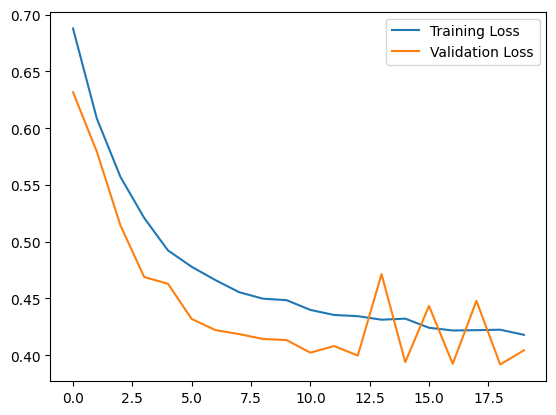

In [34]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()